In [1]:
import os
import sys
import re
import uuid
import random
import imageio
import json
import numpy as np
import torch
import torch_scatter

from scipy import misc
from PIL import Image
from tqdm import tqdm
from enum import Enum

import matplotlib.pyplot as plt

CamType = Enum("CamType", ("FirstPersonCamera", "LeftHandCamera", "RightHandCamera", "MainRoomCamera", "SecondarRoomCamera"))

for name, member in CamType.__members__.items():
    print(name, '=>', member, ',', member.value)

FirstPersonCamera => CamType.FirstPersonCamera , 1
LeftHandCamera => CamType.LeftHandCamera , 2
RightHandCamera => CamType.RightHandCamera , 3
MainRoomCamera => CamType.MainRoomCamera , 4
SecondarRoomCamera => CamType.SecondarRoomCamera , 5


/tmp/ipykernel_41873/2505755376.py:12: DeprecationWarning: scipy.misc is deprecated and will be removed in 2.0.0
  from scipy import misc


In [74]:
def ypr2rotmat(yaw, pitch, roll):
    yaw = np.deg2rad(yaw)
    pitch = np.deg2rad(pitch)
    roll = np.deg2rad(roll)
    
    yaw_matrix = np.array([[np.cos(yaw), -np.sin(yaw), 0],
                           [np.sin(yaw), np.cos(yaw), 0],
                           [0, 0, 1]])
    pitch_matrix = np.array([[np.cos(pitch), 0, np.sin(pitch)],
                             [0, 1, 0],
                             [-np.sin(pitch), 0, np.cos(pitch)]])
    roll_matrix = np.array([[1, 0, 0],
                            [0, np.cos(roll), -np.sin(roll)],
                            [0, np.sin(roll), np.cos(roll)]])
    
    return yaw_matrix @ pitch_matrix @ roll_matrix

def RGBD2PCD(rgbs, depths, intrinsics, c2ws):
    # Assuming rgbs is of shape (N, 3, H, W), depths is of shape (N, 1, H, W), and c2ws is of shape (N, 4, 4)
    N, _, H, W = rgbs.shape
    if len(intrinsics.shape) == 2:
        intrinsics = intrinsics[None]
    intrinsics = torch.tensor(intrinsics, dtype=torch.float32, device=rgbs.device)

    with torch.no_grad():
        # Create meshgrid for x and y coordinates
        pos_x, pos_y = torch.meshgrid(torch.arange(W, device=rgbs.device), torch.arange(H, device=rgbs.device), indexing='xy')
        pos_x = pos_x.unsqueeze(0).expand(N, -1, -1)  # Shape: (N, H, W)
        pos_y = pos_y.unsqueeze(0).expand(N, -1, -1)  # Shape: (N, H, W)

        # Stack x and y coordinates and reshape to (N, H*W, 2)
        p_img = torch.stack([pos_x, pos_y], dim=-1).reshape(N, -1, 2)  # Shape: (N, H*W, 2)

        # Compute x_cam and y_cam
        x_cam = (p_img[:, :, 0] - intrinsics[:, 0, 2].unsqueeze(1)) * depths.reshape(N, -1) / intrinsics[:, 0, 0].unsqueeze(1)
        y_cam = (p_img[:, :, 1] - intrinsics[:, 1, 2].unsqueeze(1)) * depths.reshape(N, -1) / intrinsics[:, 1, 1].unsqueeze(1)

        # Stack x_cam, y_cam, depth, and ones to form homogeneous coordinates
        p_cam_homo = torch.stack([x_cam, y_cam, depths.reshape(N, -1), torch.ones_like(x_cam, device=rgbs.device)], dim=-1)  # Shape: (N, H*W, 4)

        # Transform to blender coordinate system
        p_cam_homo = p_cam_homo[:, :, [2, 0, 1, 3]]
        p_cam_homo[:, 1:3] *= -1

        # Transform to world coordinates
        p_world = torch.matmul(p_cam_homo, c2ws.transpose(-2, -1))[:, :, :3]  # Shape: (N, H*W, 3)

        # Reshape rgb to (N, H*W, 3)
        rgb_world = rgbs.permute(0, 2, 3, 1).reshape(N, -1, 3)  # Shape: (N, H*W, 3)
    
    return p_world, rgb_world


In [81]:
data_folder = "../data/robotrix/000_hamburghaus_000"
cam_type = CamType.FirstPersonCamera

# load the json info
with open(os.path.join(data_folder, 'hamburghaus_000.json')) as f:
    data_info = json.load(f)
    n_images = len(data_info['frames'])

with open(os.path.join(data_folder, 'sceneObject.json')) as f:
    instance_info = json.load(f)
    for obj in instance_info['SceneObjects']:
        if obj['instance_name'] == cam_type.name:
            cam_color = np.array([obj['instance_color']['r'], obj['instance_color']['g'], obj['instance_color']['b']])
            print(obj['instance_color'])

{'r': 61, 'g': 61, 'b': 61}


c2w: 
 [[ 1.37096859e-02  9.99852096e-01 -1.03841078e-02  6.12240000e+01]
 [-9.47946533e-01  1.63007315e-02  3.18012038e-01 -1.40894000e+02]
 [ 3.18134272e-01  5.48373379e-03  9.48029806e-01  1.23072000e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


(-0.5, 1919.5, 1079.5, -0.5)

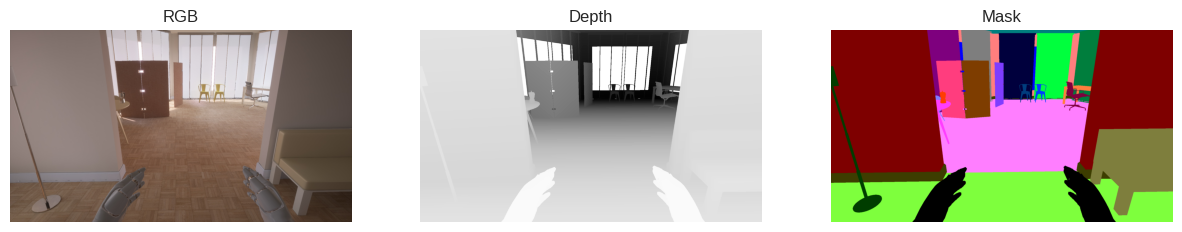

In [54]:
idx = random.randint(1, n_images+1)
img = np.array(Image.open(os.path.join(data_folder, 'rgb', cam_type.name, f"{idx:06d}.jpg")))
depth = np.array(Image.open(os.path.join(data_folder, 'depth', cam_type.name, f"{idx:06d}.png")))
mask = np.array(Image.open(os.path.join(data_folder, 'mask', cam_type.name, f"{idx:06d}.png")))
# data_info['frames'][1]['cameras'][0]['position']
cam_position = data_info['frames'][idx]['cameras'][cam_type.value-1]['position']  # x, y, z
cam_rotation = data_info['frames'][idx]['cameras'][cam_type.value-1]['rotation']  # p, y, r
fov = float(data_info['cameras'][cam_type.value-1]['fov'])
H, W = np.array(Image.open(os.path.join(data_folder, 'rgb', cam_type.name, f"{1:06d}.jpg"))).shape[:2]
f = W / (2 * np.tan(np.deg2rad(fov/2)))
intrinsics = np.array([[f, 0, W/2], [0, f, H/2], [0, 0, 1]])

# transfer string to float number'
cam_position = {k: float(v) for k, v in cam_position.items()}
cam_rotation = {k: float(v) for k, v in cam_rotation.items()}

c2w = np.eye(4)
c2w[:3, :3] = ypr2rotmat(cam_rotation['y'], cam_rotation['p'], cam_rotation['r'])
c2w[:3, 3] = np.array([cam_position['x'], cam_position['y'], cam_position['z']])
print("c2w: \n", c2w)

plt.style.use("seaborn-v0_8-whitegrid")
plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.imshow(img)
plt.title("RGB")
plt.axis("off")

plt.subplot(132)
plt.imshow(depth)
plt.title("Depth")
plt.axis("off")

plt.subplot(133)
plt.imshow(mask)
plt.title("Mask")
plt.axis("off")

Text(0.5, 1.0, 'Camera Positions')

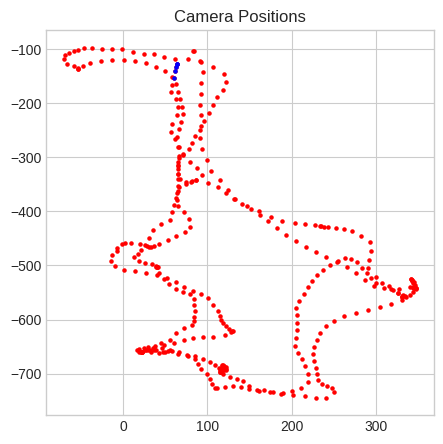

In [51]:
# draw the camera positions
plt.style.use("seaborn-v0_8-whitegrid")
plt.figure(figsize=(5, 5))
for i in range(0, n_images, 20):
    cam_position = data_info['frames'][i]['cameras'][cam_type.value-1]['position']
    cam_position = {k: float(v) for k, v in cam_position.items()}
    plt.scatter(cam_position['x'], cam_position['y'], c='r', s=5)

for i in range(0, 100, 20):
    cam_position = data_info['frames'][i]['cameras'][cam_type.value-1]['position']
    cam_position = {k: float(v) for k, v in cam_position.items()}
    plt.scatter(cam_position['x'], cam_position['y'], c='b', s=5)

plt.title("Camera Positions")

In [85]:
imgs, depths, masks, c2ws = [], [], [], []
for i in range(1, n_images+1, 1000):
    img = np.array(Image.open(os.path.join(data_folder, 'rgb', cam_type.name, f"{i:06d}.jpg")))
    depth = np.array(Image.open(os.path.join(data_folder, 'depth', cam_type.name, f"{i:06d}.png"))) / 10.0
    mask = np.array(Image.open(os.path.join(data_folder, 'mask', cam_type.name, f"{i:06d}.png")))[..., :3]
    imgs.append(img)
    depths.append(depth)
    masks.append(mask)

    cam_position = data_info['frames'][i]['cameras'][cam_type.value-1]['position']
    cam_position = {k: float(v) for k, v in cam_position.items()}
    cam_rotation = data_info['frames'][i]['cameras'][cam_type.value-1]['rotation']
    cam_rotation = {k: float(v) for k, v in cam_rotation.items()}
    c2w = np.eye(4)
    c2w[:3, :3] = ypr2rotmat(cam_rotation['y'], cam_rotation['p'], cam_rotation['r'])
    c2w[:3, 3] = np.array([cam_position['x'], cam_position['y'], cam_position['z']])
    c2ws.append(c2w)

    print(c2w)

rgbs = np.stack(imgs, axis=0).transpose(0, 3, 1, 2)
depths = np.stack(depths, axis=0)[:, None]
masks = np.stack(masks, axis=0)
c2ws = np.stack(c2ws, axis=0)

p_world, rgb_world = RGBD2PCD(torch.tensor(rgbs, dtype=torch.float32), torch.tensor(depths, dtype=torch.float32), intrinsics, torch.tensor(c2ws, dtype=torch.float32))
pcd_mask = masks.reshape(-1, 3)
pcd_mask = (pcd_mask[:, 0] == 0) & (pcd_mask[:, 1] == 0) & (pcd_mask[:, 2] == 0)
pcd_mask = ~pcd_mask
pcd_xyz = p_world.cpu().numpy().reshape(-1, 3)[pcd_mask][::100]
pcd_rgb = rgb_world.cpu().numpy().reshape(-1, 3)[pcd_mask][::100]

[[-2.53966073e-02  9.99658381e-01  6.17531088e-03  6.43970000e+01]
 [-9.88201198e-01 -2.60379039e-02  1.50931841e-01 -1.28136000e+02]
 [ 1.51041072e-01 -2.26929291e-03  9.88524883e-01  1.23993000e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[ 4.60118178e-01  7.09683237e-01 -5.33517541e-01  3.46452000e+02]
 [-6.30130945e-01  6.84349569e-01  3.66879625e-01 -5.41050000e+02]
 [ 6.25480819e-01  1.67377927e-01  7.62075045e-01  1.19720000e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[-7.86786881e-01 -4.80838627e-01  3.86989170e-01  1.14633000e+02]
 [ 4.04944335e-01 -8.75311024e-01 -2.64292824e-01 -6.96083000e+02]
 [ 4.65818086e-01 -5.12330550e-02  8.83396109e-01  1.21595000e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[-7.79583501e-01 -5.14807339e-01  3.56683288e-01  1.21671000e+02]
 [ 4.64156025e-01 -8.57267098e-01 -2.22827975e-01 -6.11896000e+02]
 [ 4.20486325e-01 -8.15631610e-03  9.07262214e-01  1.220500

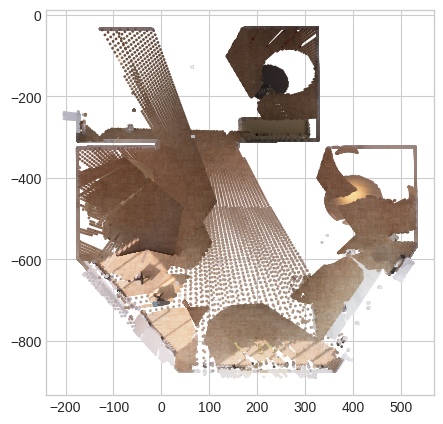

In [86]:
plt.style.use("seaborn-v0_8-whitegrid")
plt.figure(figsize=(5, 5))
plt.scatter(pcd_xyz[:, 0], pcd_xyz[:, 1], c=pcd_rgb[:] / 255, s=1)

In [77]:
from plyfile import PlyData, PlyElement
# 确保输入数组形状正确
assert pcd_xyz.shape[0] == pcd_rgb.shape[0], "坐标和颜色数组的点数量不一致"
assert pcd_xyz.shape[1] == 3, "坐标数组应为(N, 3)"
assert pcd_rgb.shape[1] == 3, "颜色数组应为(N, 3)"

# 转换颜色到uint8（假设颜色值在0-255或0-1范围内）
if pcd_rgb.dtype != np.uint8:
    if np.max(pcd_rgb) <= 1.0:
        pcd_rgb = (pcd_rgb * 255).astype(np.uint8)
    else:
        pcd_rgb = pcd_rgb.astype(np.uint8)

# 创建结构化数组
vertex_dtype = [('x', 'f4'), ('y', 'f4'), ('z', 'f4'),
                ('red', 'u1'), ('green', 'u1'), ('blue', 'u1')]
vertices = np.empty(pcd_xyz.shape[0], dtype=vertex_dtype)

# 填充数据
vertices['x'] = pcd_xyz[:, 0].astype('f4')
vertices['y'] = pcd_xyz[:, 1].astype('f4')
vertices['z'] = pcd_xyz[:, 2].astype('f4')
vertices['red'] = pcd_rgb[:, 0]
vertices['green'] = pcd_rgb[:, 1]
vertices['blue'] = pcd_rgb[:, 2]

# 生成并保存PLY文件
ply_element = PlyElement.describe(vertices, 'vertex')
PlyData([ply_element]).write('colored_point_cloud.ply')